# 2D Moving Heat Source with PINNs
## Code developed by Anirudh Kalyan 

![Image Description](GeomDes.jpeg)


The following boundary and heat source are implemented in this code. The boundary conditions are as follows

\begin{equation}
\left\{
    \begin{aligned}
        {\rm Along~A-D},~\Gamma_{AD}: &~T = 298 K \\
        {\rm Along~A-B},~\Gamma_{AB}: &~\mathbf{q}\cdot \mathbf{n} = 0.001 W/mm^2 \\
        {\rm Along~B-C},~\Gamma_{AB}: &~\mathbf{q}\cdot \mathbf{n}  = 0.001 W/mm^2 \\
        {\rm Along~C-D},~\Gamma_{CD}: &~\mathbf{q}\cdot \mathbf{n} = 0.001 W/mm^2
    \end{aligned}
\right.
\end{equation}

v = 0.5mm/s in this run

## Importing Libraries

In [1]:
%matplotlib inline
import os
import time
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from jax import jvp, vjp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from matplotlib import rcParams

## Defining Constants

In [ ]:
xmin = 0.0
xmax = 20.0
ymin = 0.0
ymax = 10.0
tmin = 0.0 
tmax = 3.0

In [ ]:
NC=128**2
NI=96**2
NB=96**2
NC_TEST=100
SEED=444
LR=1e-3
EPOCHS=20000
N_LAYERS=9 
FEATURES=128
delt = 1.0
runs = int((tmax-tmin)//delt)

cmin = 0 
cmax = 250

In [3]:
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "cmr10"  # Computer Modern Roman
rcParams["font.size"] = 14  # Set font size to 14

In [4]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Defining PINN

In [5]:
# forward function
class PINN(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, y, z):
        X = jnp.concatenate([x, y, z], axis=1) 
        init = nn.initializers.glorot_normal()
        for fs in self.features[:-1]:
            X = nn.Dense(fs, kernel_init=init)(X) 
            X = nn.activation.tanh(X)
        X = nn.Dense(self.features[-1], kernel_init=init)(X)
        return X 



# hessian-vector product
def hvp_fwdfwd(f, primals, tangents, return_primals=False): 
    g = lambda primals: jvp(f, (primals,), tangents)[1] 
    primals_out, tangents_out = jvp(g, primals, tangents) 
    if return_primals:  
        return primals_out, tangents_out
    else:
        return tangents_out 

# loss function
def pinn_loss(apply_fn, *train_data):
    def residual_loss(params, t, x, y, source_term): #equation loss
        # compute u
        u = apply_fn(params, t, x, y)
        v = jnp.ones([u.shape[0],1]) 
        # 2nd derivatives of u
        rho = 7.6e-6
        c = 658
        k = 25e-3
        ut_f =  vjp(lambda t: apply_fn(params, t, x, y), t)[1]
        ut = ut_f(v)[0]
        uxx = hvp_fwdfwd(lambda x: apply_fn(params, t, x, y), (x,), (v,))
        uyy = hvp_fwdfwd(lambda y: apply_fn(params, t, x, y), (y,), (v,))
        return jnp.mean(jnp.square(rho*c*ut/k - uxx - uyy + - source_term/k))
    
    def initial_loss(params, t, x, y, u):
        return jnp.mean(jnp.square(apply_fn(params, t, x, y) - u)) #data loss, that corresponds to initial conditions. 
    
    def boundary_loss_neumann(params, t, x, y, u_gt): #equation loss
        # compute u
        u = apply_fn(params, t, x, y)
        v = jnp.ones([u.shape[0],1]) 
        ux_f =  vjp(lambda x: apply_fn(params, t, x, y), x)[1]
        ux = ux_f(v)[0]
        uy_f =  vjp(lambda y: apply_fn(params, t, x, y), y)[1]
        uy = uy_f(v)[0]
        
        result = jnp.where(
            (x == xmax),
            ux-u_gt,
            jnp.where(
                (y == ymin) | (y == ymax),
                uy-u_gt,
                u_gt
            )
        )  #Neumann Condition
        
        return jnp.mean(jnp.square(result))
    
    def boundary_loss_direchlet(params, t, x, y, u_gt): #equation loss
        return jnp.mean(jnp.square(apply_fn(params, t, x, y) - u_gt)) 


    # unpack data
    tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = train_data
    
    mask = xb == xmin
    D_Indices = jnp.where(mask)[0]
    xdb = xb[D_Indices]
    ydb = yb[D_Indices]
    tdb = tb[D_Indices]
    udb = ub[D_Indices]
    
    D_Indices = jnp.where(~mask)[0]
    xnb = xb[D_Indices]
    ynb = yb[D_Indices]
    tnb = tb[D_Indices]
    unb = ub[D_Indices]
    
    


    # isolate loss function from redundant arguments
    fn = lambda params: 1e3*residual_loss(params, tc, xc, yc, uc) + \
                        250*initial_loss(params, ti, xi, yi, ui) + \
                        250*boundary_loss_neumann(params, tnb, xnb, ynb, unb) + \
                            250*boundary_loss_direchlet(params, tdb, xdb, ydb, udb)

    return fn

# optimizer step function
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

## Source Term & Data Generator

In [ ]:
# 2d time-dependent source term
def q(pos,t):
    r0 = 1
    q0 = 5
    
    muy = 5*jnp.ones((len(t),1))
    mux = 19*jnp.ones((len(t),1)) - 0.5*t 
    x= pos[:,0].reshape(-1,1)
    y = pos[:,1].reshape(-1,1)    
    r2 = jnp.square((x-mux)) + jnp.square((y-muy)) 
    u = q0*jnp.exp(-r2/(r0**2))
    return u

In [ ]:
# train data
def pinn_training_data_generator(nc, ni, nb, key):
    keys = jax.random.split(key, 13)
    # collocation points
    tc = jax.random.uniform(keys[0], (nc, 1), minval= tmin, maxval= tmax)
    xc = jax.random.uniform(keys[1], (nc, 1), minval= xmin, maxval= xmax)
    yc = jax.random.uniform(keys[2], (nc, 1), minval= ymin, maxval= ymax)
    uc = q(jnp.concatenate([xc,yc],axis=1),tc)
    # initial points
    ti = jnp.zeros((ni, 1))
    xi = jax.random.uniform(keys[3], (ni, 1), minval= xmin, maxval= xmax)
    yi = jax.random.uniform(keys[4], (ni, 1), minval= ymin, maxval= ymax)
    ui = 20*jnp.ones((ni,1))
    
    # boundary points (hard-coded)
    tb = [
        jax.random.uniform(keys[5], (nb, 1), minval= tmin, maxval= tmax),
        jax.random.uniform(keys[6], (nb, 1), minval= tmin, maxval= tmax),
        jax.random.uniform(keys[7], (nb, 1), minval= tmin, maxval= tmax),
        jax.random.uniform(keys[8], (nb, 1), minval= tmin, maxval= tmax)
    ]
    xb = [
        jnp.array([[xmin]]*nb),
        jnp.array([[xmax]]*nb),
        jax.random.uniform(keys[9], (nb, 1), minval= xmin, maxval= xmax),
        jax.random.uniform(keys[10], (nb, 1), minval= xmin , maxval= xmax)
    ]
    yb = [
        jax.random.uniform(keys[11], (nb, 1), minval= ymin, maxval= ymax),
        jax.random.uniform(keys[12], (nb, 1), minval= ymin, maxval= ymax),
        jnp.array([[ymin]]*nb),
        jnp.array([[ymax]]*nb)
    ]
    ub = [20*jnp.ones((nb,1)),
          -0.001*jnp.ones((nb,1)),
          0.001*jnp.ones((nb,1)),
          -0.001*jnp.ones((nb,1))]
        
    tb = jnp.concatenate(tb)
    xb = jnp.concatenate(xb)
    yb = jnp.concatenate(yb)
    ub = jnp.concatenate(ub)
    
    return tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub

# test data
def pinn_test_data_generator(nc_test,ts=0):
    t = jnp.array([ts])#jnp.linspace(0, 10, nc_test)
    x = jnp.linspace(xmin, xmax, nc_test)
    y = jnp.linspace(ymin, ymax, nc_test)
    t = jax.lax.stop_gradient(t)
    x = jax.lax.stop_gradient(x)
    y = jax.lax.stop_gradient(y)
    tm, xm, ym = jnp.meshgrid(t, x, y, indexing='ij')
    t = tm.reshape(-1, 1)
    x = xm.reshape(-1, 1)
    y = ym.reshape(-1, 1)
    u_gt = u_gt.reshape(-1, 1)

    return t, x, y,tm,xm,ym

## Main

In [11]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2) 
tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = pinn_training_data_generator(NC, NI, NB, subkey)

100%|██████████| 20000/20000 [07:21<00:00, 45.25it/s]
/tmp/ipykernel_1840889/1461808121.py:67: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 22.12 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:83: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:87: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:102: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:19<00:00, 45.50it/s]
/tmp/ipykernel_1840889/1461808121.py:211: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 22.00 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:19<00:00, 45.53it/s]
/tmp/ipykernel_1840889/1461808121.py:211: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 21.98 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:19<00:00, 45.51it/s]
/tmp/ipykernel_1840889/1461808121.py:211: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 21.99 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:17<00:00, 45.68it/s]
/tmp/ipykernel_1840889/1461808121.py:211: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 21.91 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:19<00:00, 45.48it/s]
/tmp/ipykernel_1840889/1461808121.py:211: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 22.01 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:18<00:00, 45.57it/s]
/tmp/ipykernel_1840889/1461808121.py:211: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


Runtime: 21.97 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
100%|██████████| 20000/20000 [07:19<00:00, 45.53it/s]


Runtime: 21.98 ms/iter.


/tmp/ipykernel_1840889/1461808121.py:223: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))
/tmp/ipykernel_1840889/1461808121.py:227: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax)
/tmp/ipykernel_1840889/1461808121.py:241: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(14, 6))


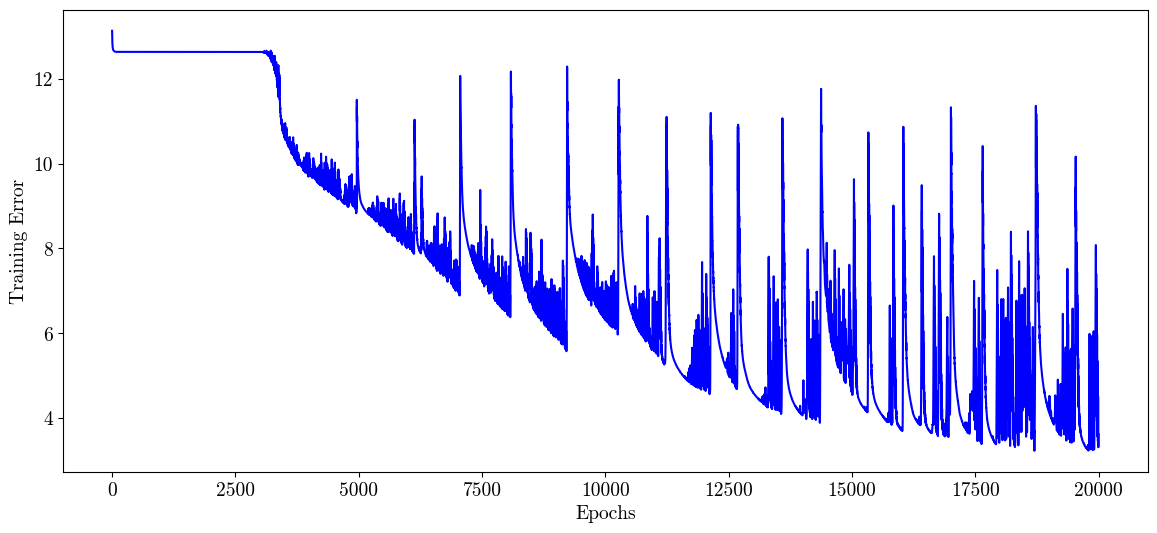

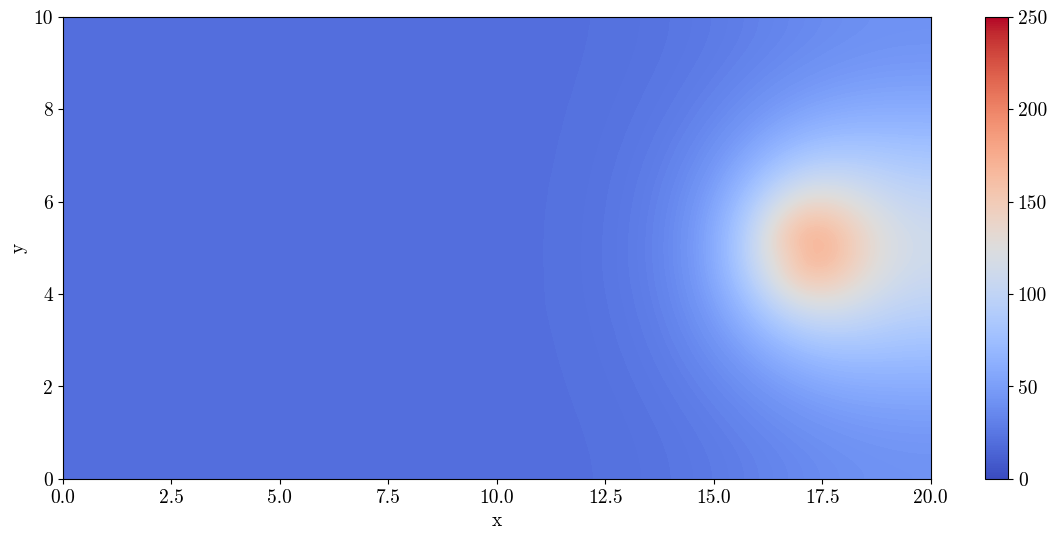

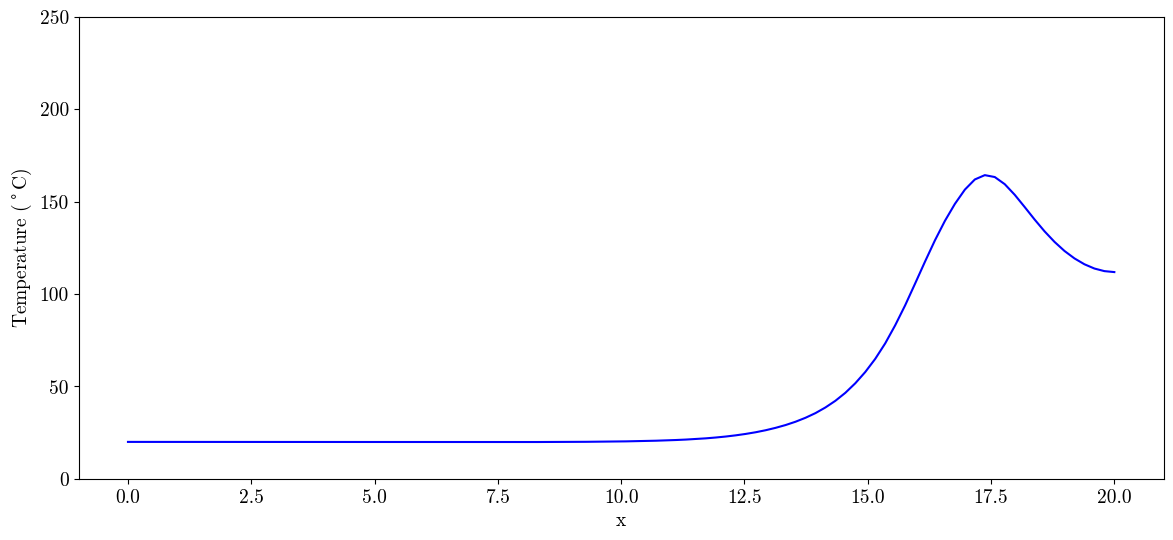

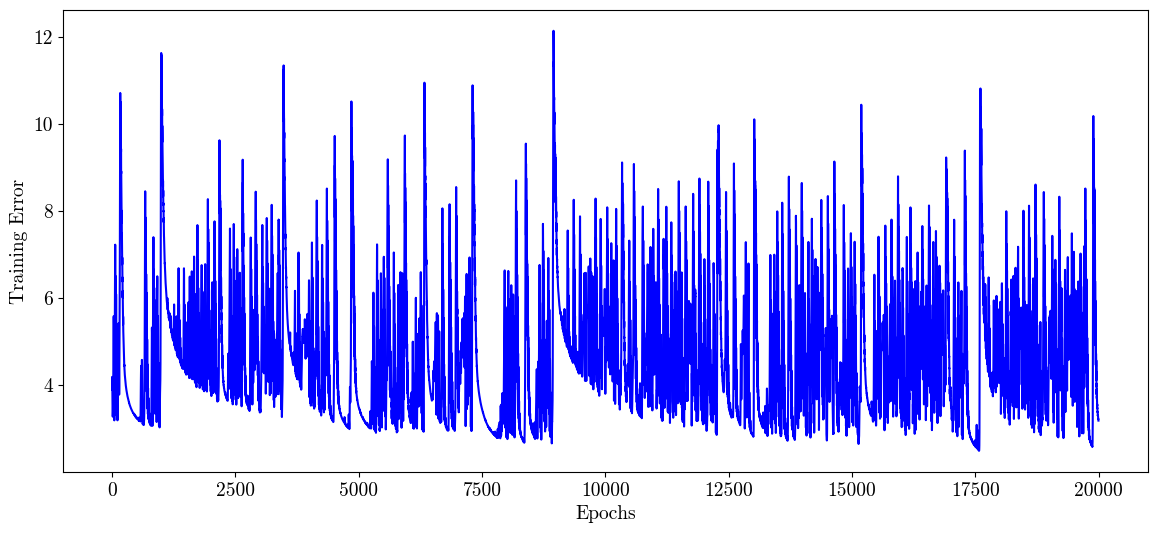

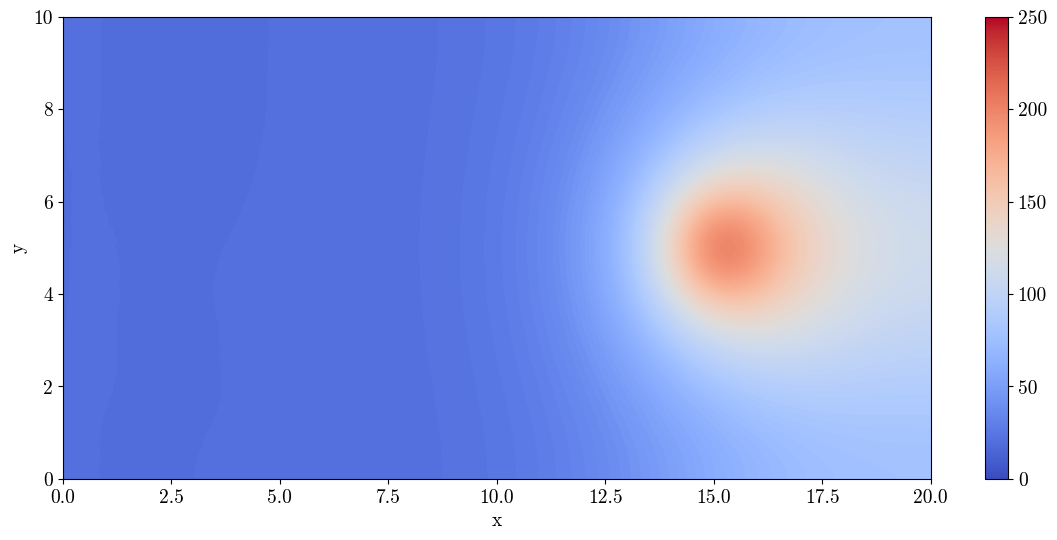

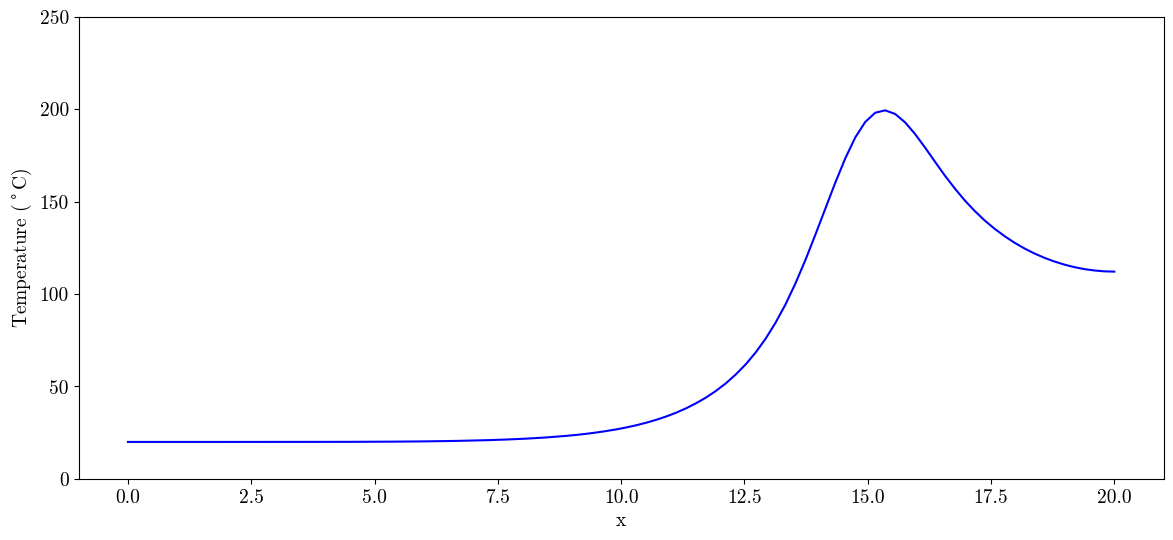

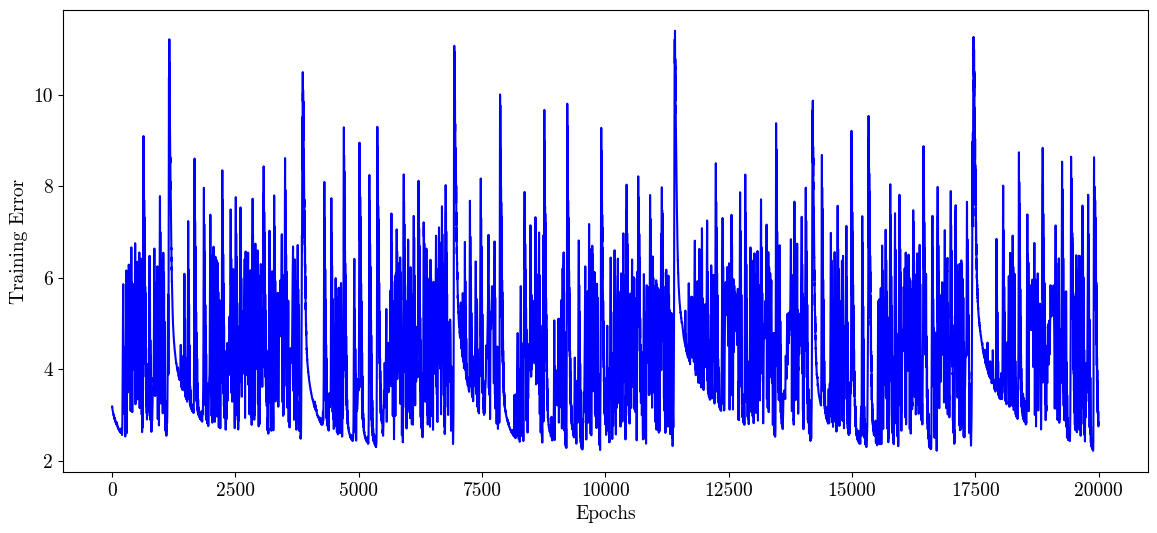

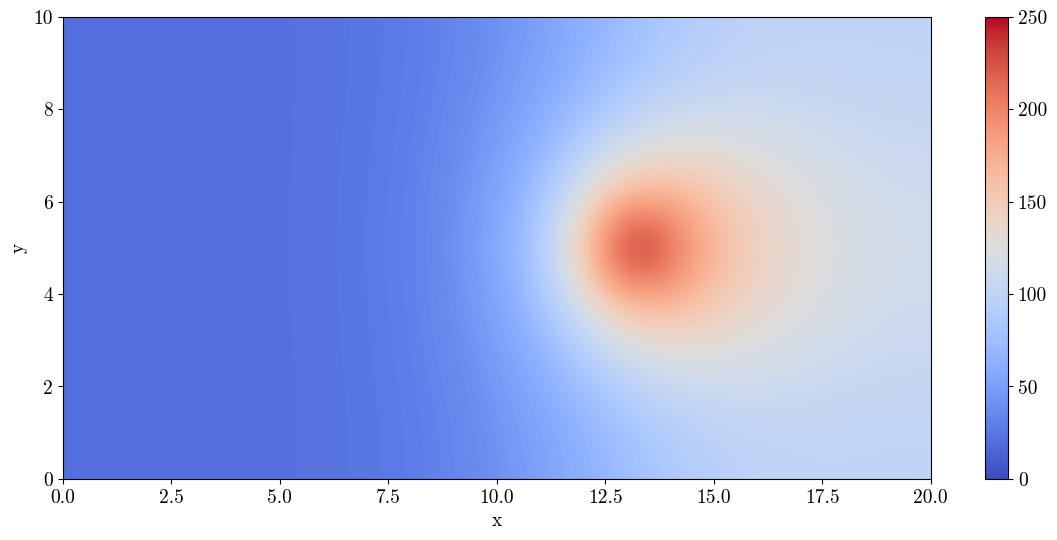

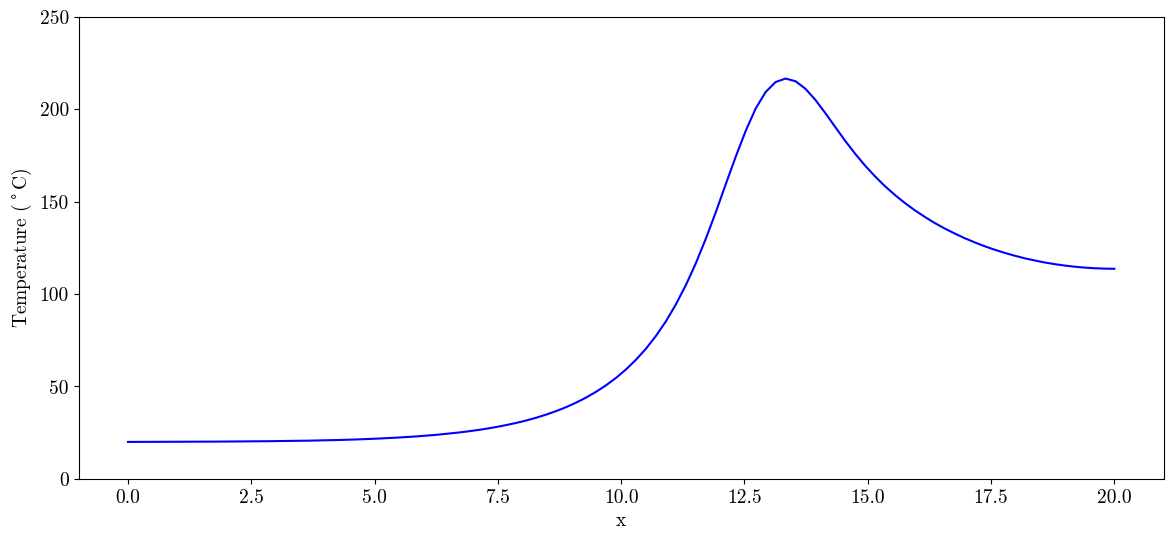

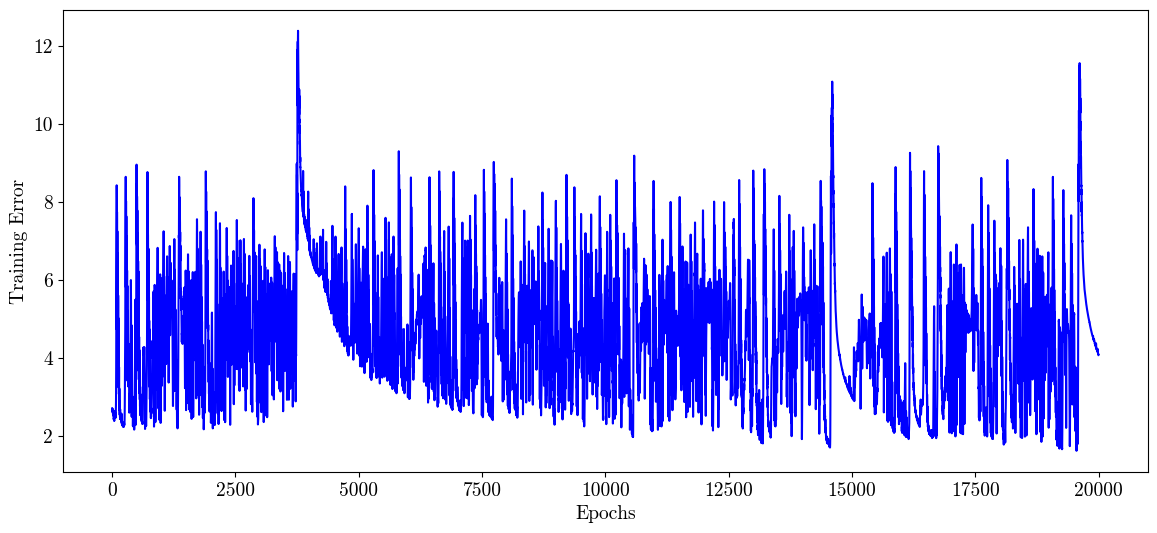

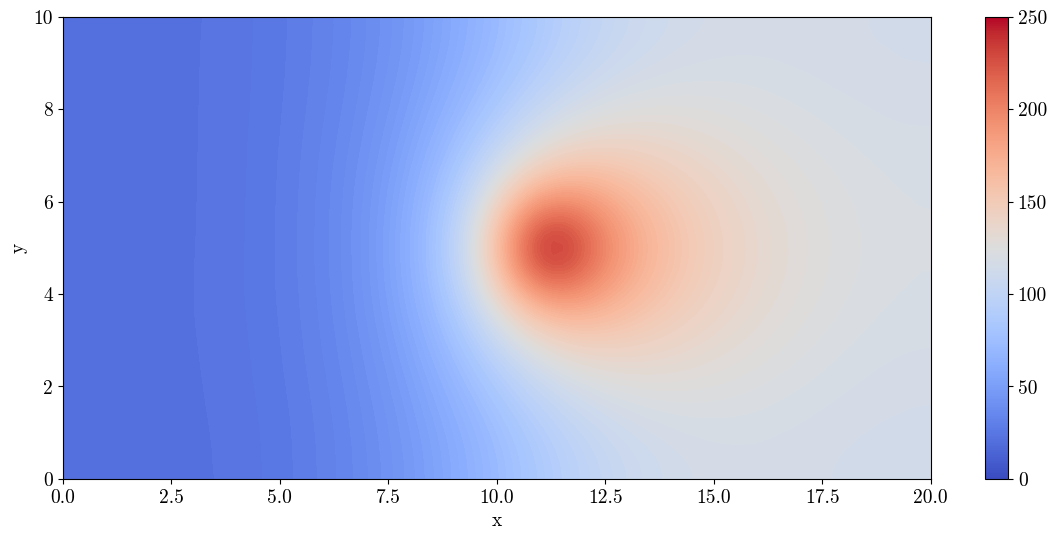

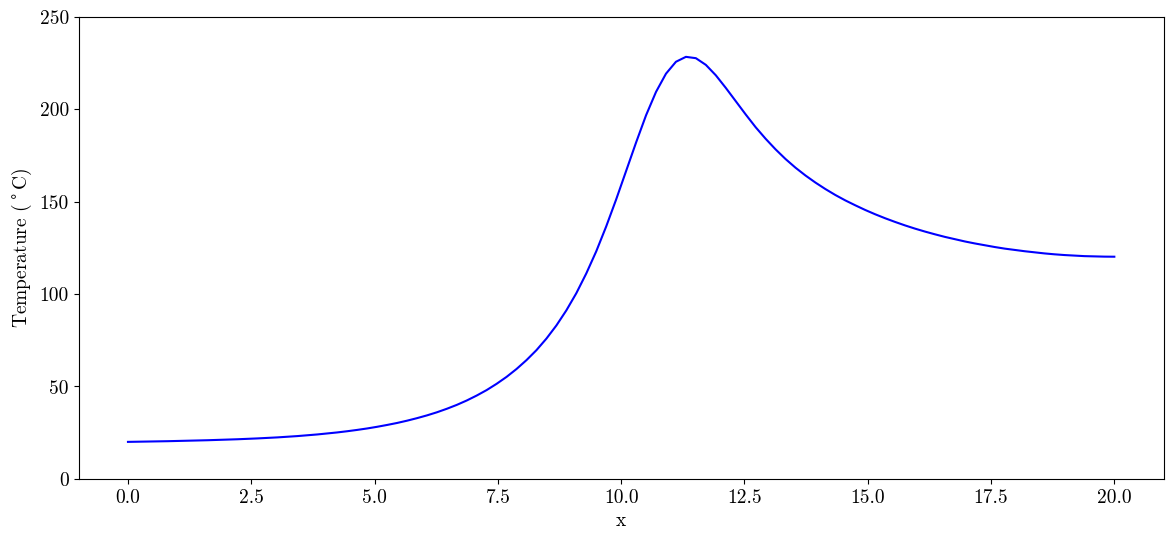

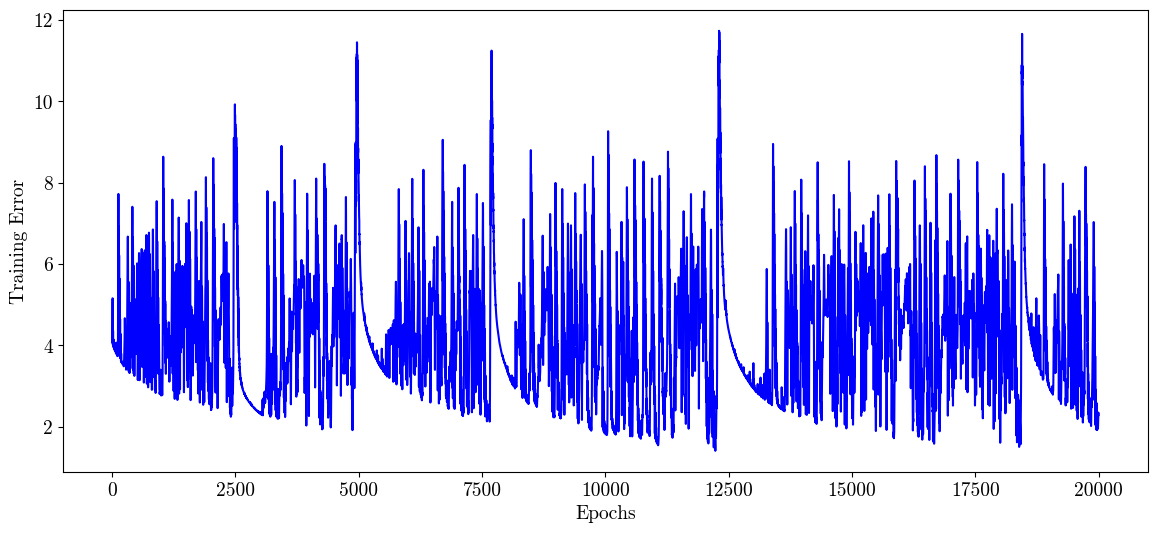

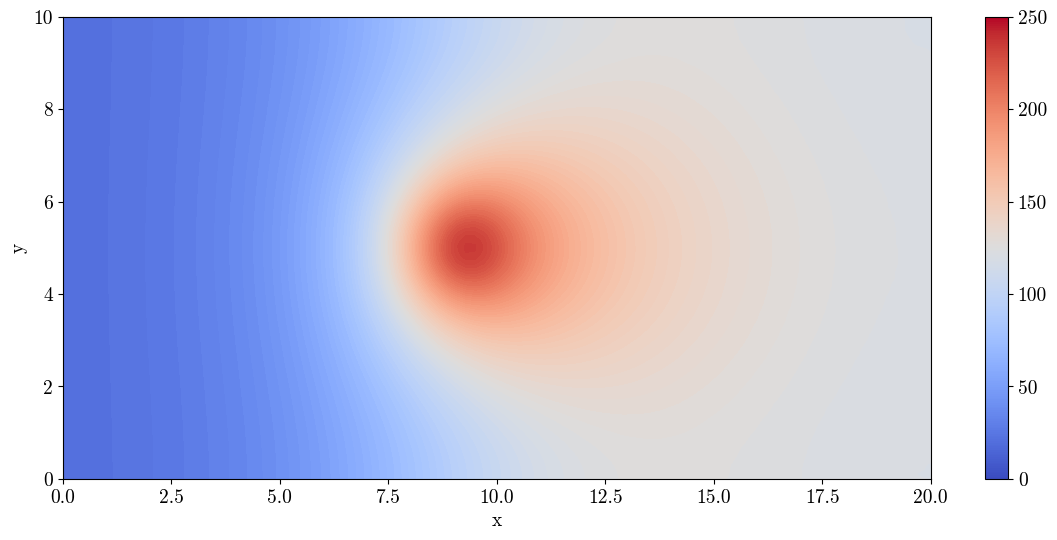

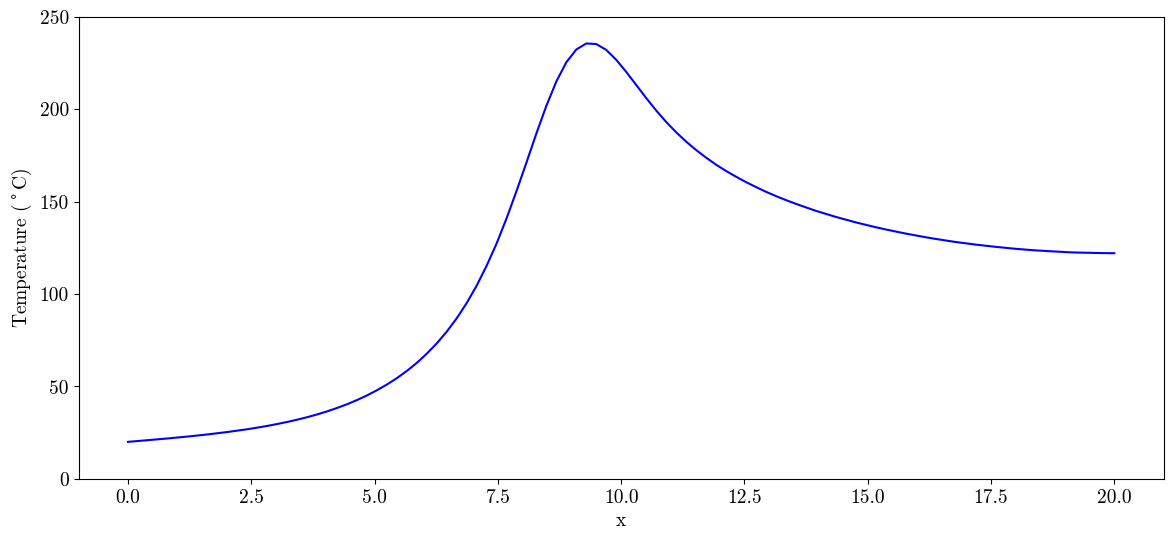

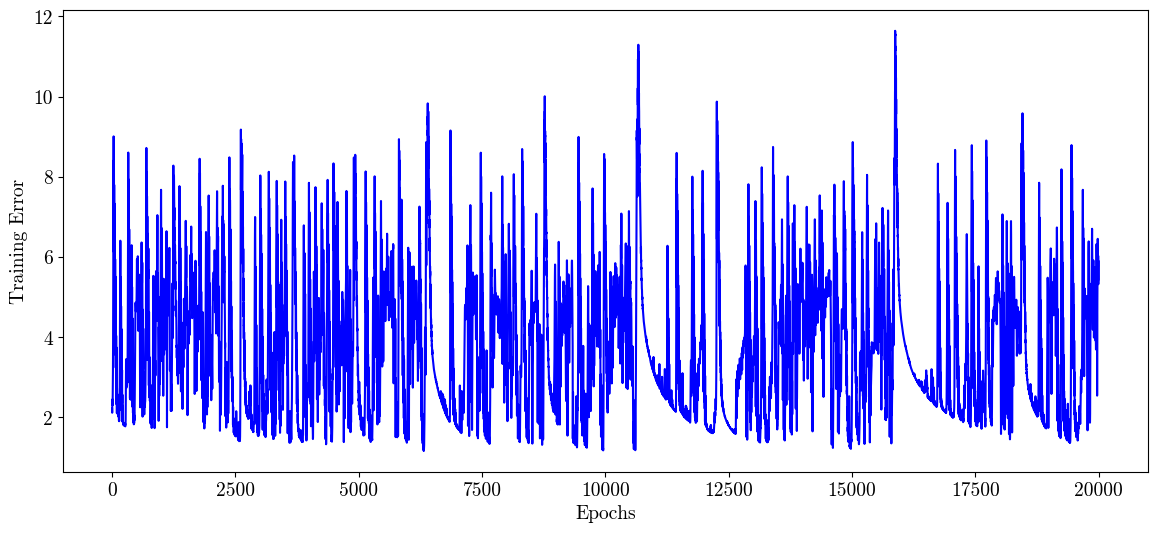

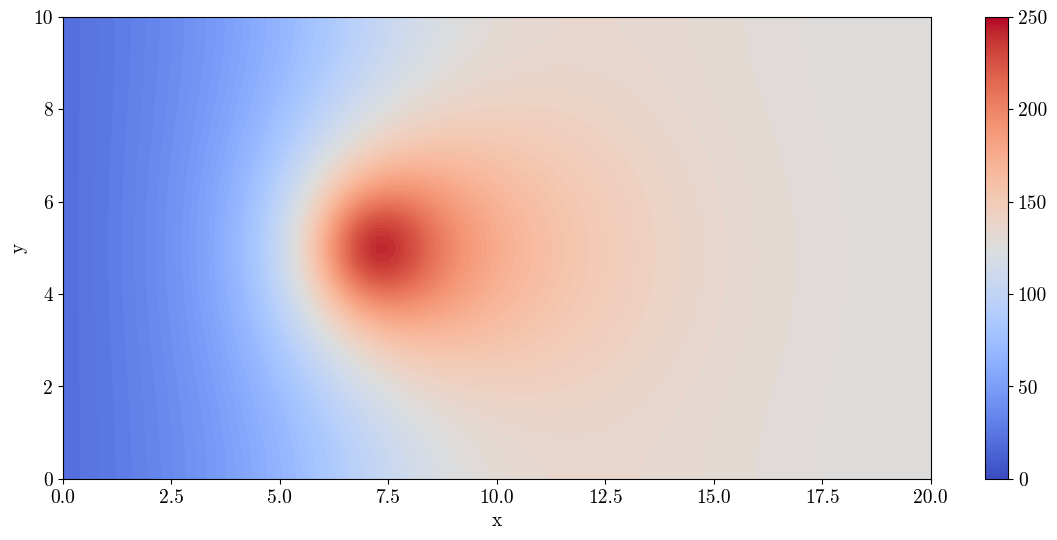

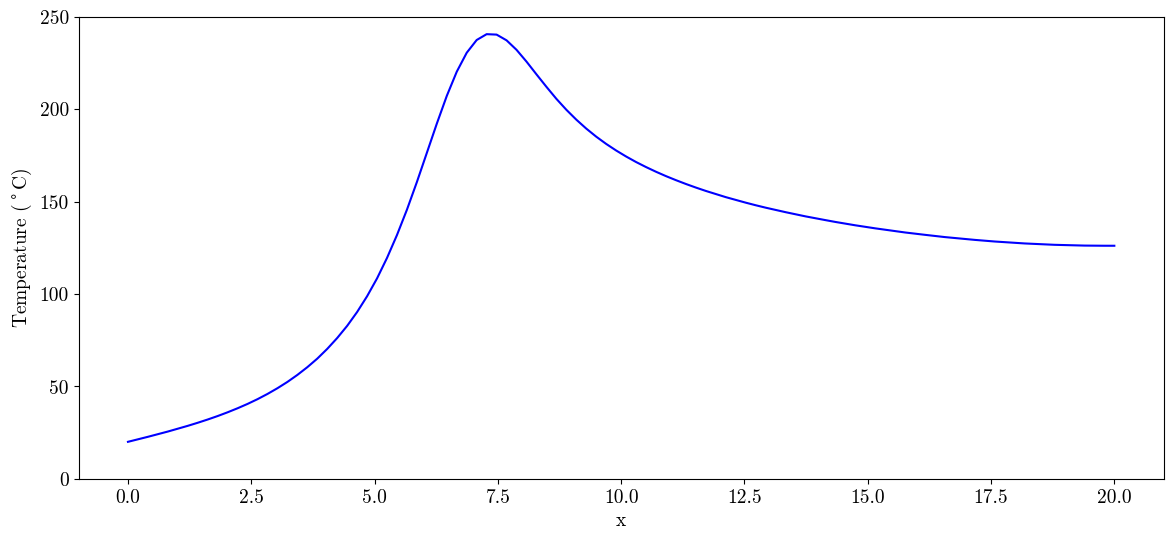

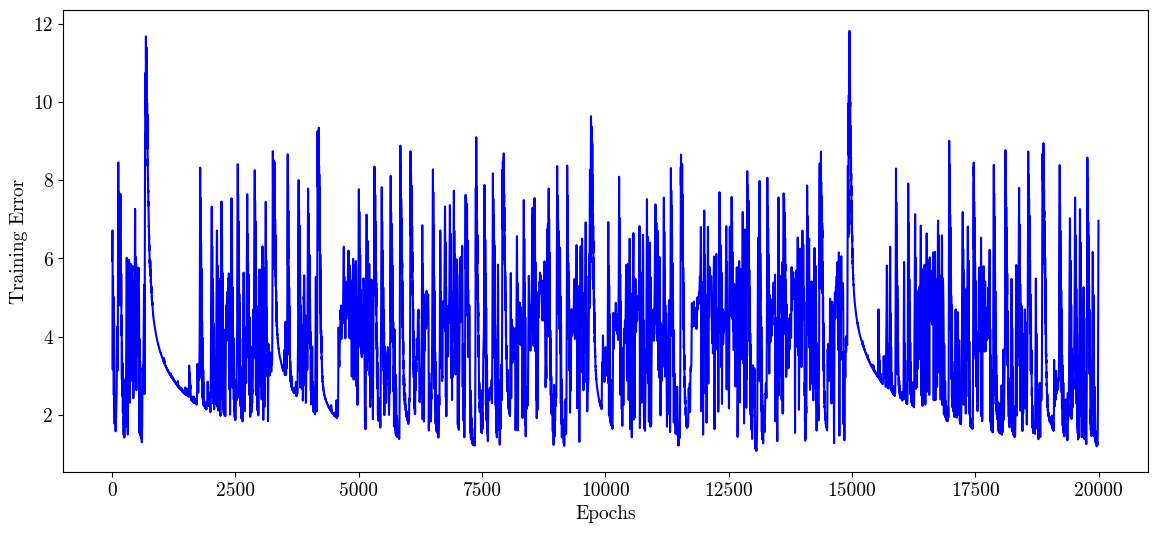

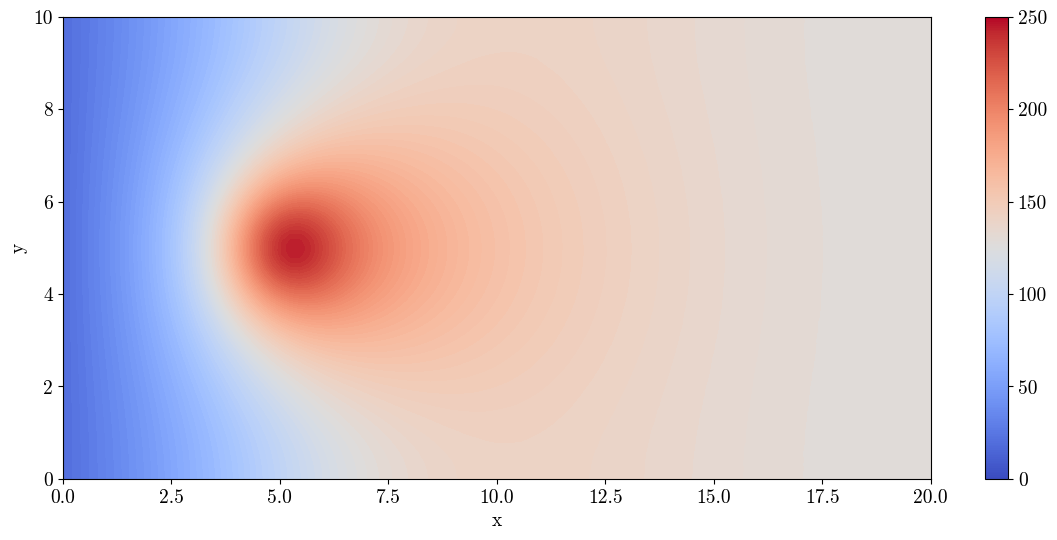

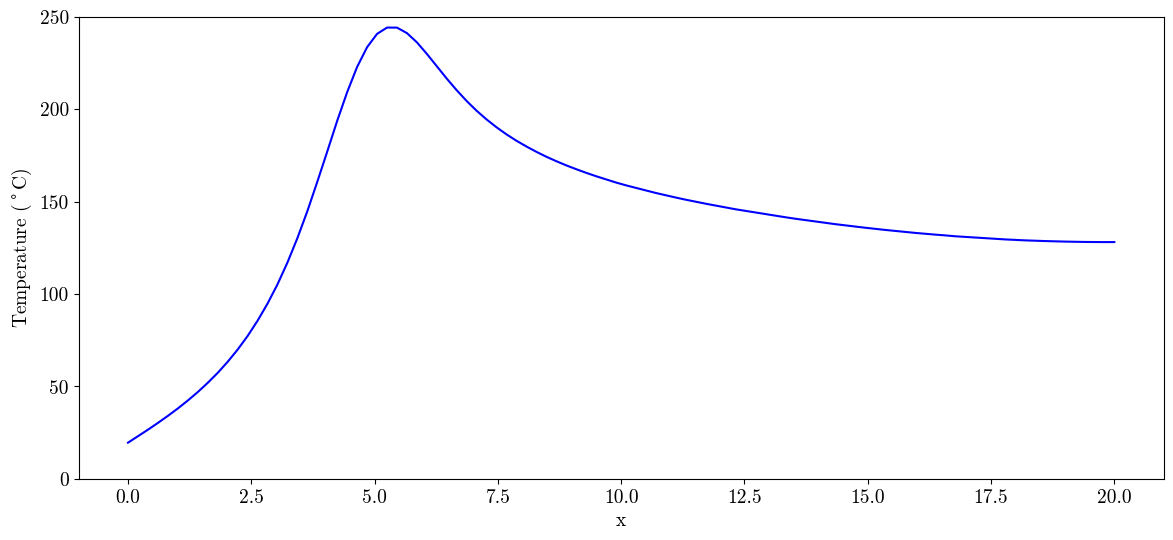

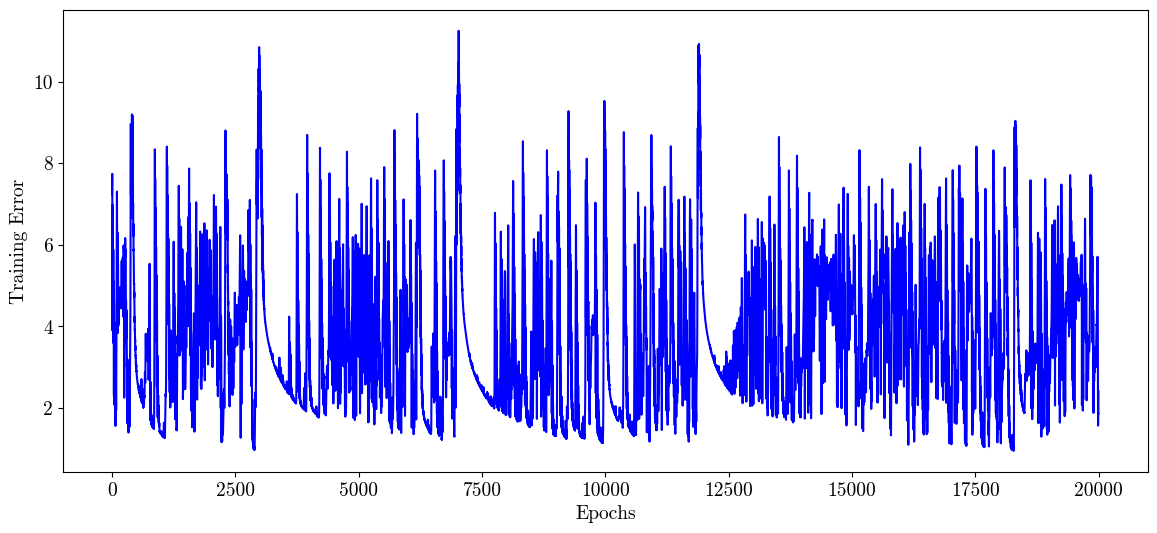

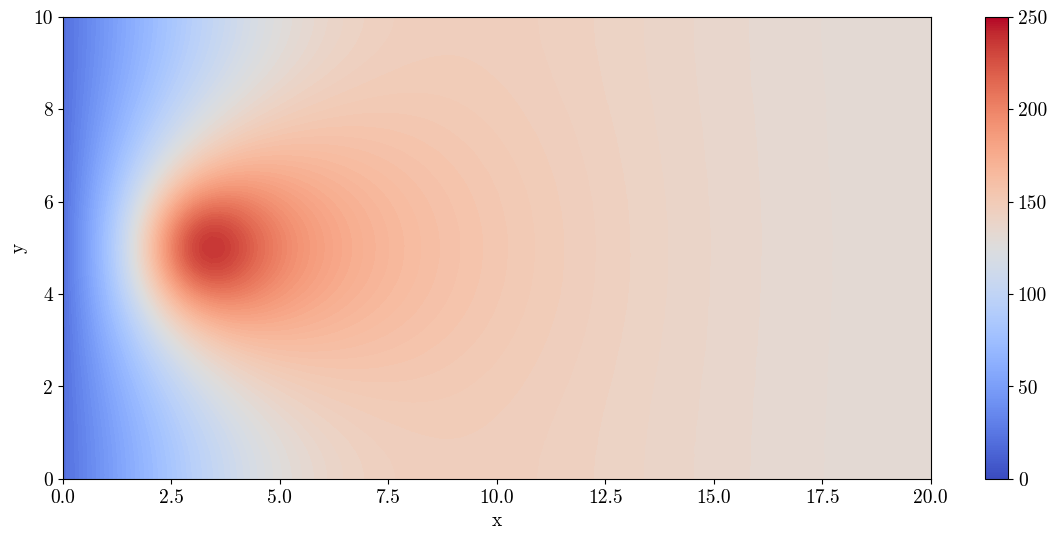

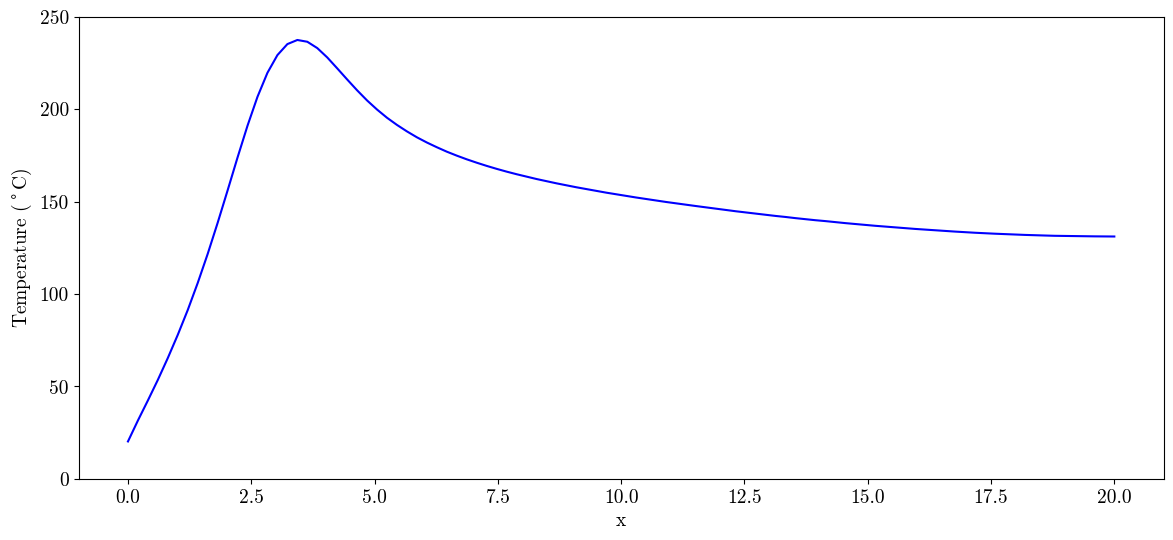

In [12]:
# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2) 

# feature sizes
feat_sizes = tuple([FEATURES for _ in range(N_LAYERS - 1)] + [1]) 

# make & init model
model = PINN(feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)), jnp.ones((NC, 1)))

# optimizer
optim = optax.adam(LR)
state = optim.init(params)

# dataset
key, subkey = jax.random.split(key, 2)
train_data = pinn_training_data_generator(NC, NI, NB, subkey)
t, x, y,tm,xm,ym = pinn_test_data_generator(NC_TEST)

# forward & loss function
apply_fn = jax.jit(model.apply)
loss_fn = pinn_loss(apply_fn, *train_data)



@jax.jit
def train_one_step(params, state):
    # compute loss and gradient
    loss, gradient = value_and_grad(loss_fn)(params)
    # update state
    params, state = update_model(optim, gradient, params, state)
    return loss, params, state

start = time.time()

lise = []
for e in trange(1, EPOCHS+1):
    # single run
    loss, params, state = train_one_step(params, state)
    lise.append(np.log(loss))
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(lise,color="blue")
ax.set_xlabel("Epochs", fontstyle="italic")
ax.set_ylabel("Training Error", fontstyle="italic")
plt.savefig(f"Error_Plot{tmin+delt}s.png", dpi=200, bbox_inches="tight")


end = time.time()
print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')



 
t, x, y, u_gt, tm, xm, ym = pinn_test_data_generator(NC_TEST,tmin+delt)
u = apply_fn(params, t, x, y)
u = u.reshape(xm.shape[1],xm.shape[2])
fig, ax = plt.subplots(figsize=(14, 6))
contour = plt.contourf(xm.squeeze(), ym.squeeze(), u.squeeze(), levels=100, cmap='coolwarm', vmin=cmin, vmax=cmax)  
norm = Normalize(vmin=cmin, vmax=cmax)
sm = ScalarMappable(cmap="coolwarm", norm=norm)
cbar = plt.colorbar(sm, ax=ax)
ax.set_xlabel("x",fontstyle="italic")
ax.set_ylabel("y",fontstyle="italic")
plt.savefig(f"temperature_field{tmin+delt}s.png", dpi=200, bbox_inches='tight')

nx = np.array(xm.flatten().squeeze())
ny = np.array(ym.flatten().squeeze())
nu = np.array(u.flatten().squeeze())

csvarray = np.column_stack((nx,ny,nu))
np.savetxt(f"Contour_data{tmin+delt}.csv",csvarray,delimiter=',',header='x,y,t')


y = 5*jnp.ones_like(x)
u = apply_fn(params, t, x, y)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(x, u,color="blue")
plt.ylim(cmin, cmax)
ax.set_xlabel("x", fontstyle="italic")
ax.set_ylabel("Temperature ($^\circ$C)", fontstyle="italic")
plt.savefig(f"Line_temperature_field{tmin+delt}s.png", dpi=200, bbox_inches="tight")

lx = np.array(x.squeeze())
lu = np.array(u.squeeze())

csvarray = np.column_stack((lx,lu))
np.savetxt(f"Line_data{tmin+delt}.csv",csvarray,delimiter=',',header='x,t')

for r in range(1,runs): #Beginning recursive training
    
    tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = train_data
    ti = ti+delt
    tc = tc+delt
    tb = tb+delt
    
    ui = apply_fn(params, ti, xi, yi)
    uc = q(jnp.concatenate([xc,yc],axis=1),tc)
    
    train_data = tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub
        
    @jax.jit
    def train_one_step(params, state):
        # compute loss and gradient
        loss, gradient = value_and_grad(loss_fn)(params)
        # update state
        params, state = update_model(optim, gradient, params, state)
        return loss, params, state


    start = time.time()


    lise = []
    for e in trange(1, EPOCHS+1):
        # single run
        loss, params, state = train_one_step(params, state)
        lise.append(np.log(loss))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(lise,color="blue")
    ax.set_xlabel("Epochs", fontstyle="italic")
    ax.set_ylabel("Training Error", fontstyle="italic")
    plt.savefig(f"Error_Plot{r}.png", dpi=200, bbox_inches="tight")

    end = time.time()
    print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

    t, x, y, u_gt, tm, xm, ym = pinn_test_data_generator(NC_TEST,tmin+(r+1)*delt)
    u = apply_fn(params, t, x, y)
    u = u.reshape(xm.shape[1],xm.shape[2])
    fig, ax = plt.subplots(figsize=(14, 6))
    contour = plt.contourf(xm.squeeze(), ym.squeeze(), u.squeeze(), levels=100, cmap='coolwarm', vmin=cmin, vmax=cmax)  # Use levels for smoothness
    norm = Normalize(vmin=cmin, vmax=cmax)
    sm = ScalarMappable(cmap="coolwarm", norm=norm)
    cbar = plt.colorbar(sm, ax=ax)
    ax.set_xlabel("x",fontstyle="italic")
    ax.set_ylabel("y",fontstyle="italic")
    plt.savefig(f"temperature_field{tmin+(r+1)*delt}s.png", dpi=200, bbox_inches='tight')

    nx = np.array(xm.flatten().squeeze())
    ny = np.array(ym.flatten().squeeze())
    nu = np.array(u.flatten().squeeze())

    csvarray = np.column_stack((nx,ny,nu))
    np.savetxt(f"Contour_data{tmin+(r+1)*delt}.csv",csvarray,delimiter=',',header='x,y,t')

    y = 5*jnp.ones_like(x)
    u = apply_fn(params, t, x, y)
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(x, u,color="blue")
    plt.ylim(cmin, cmax)
    ax.set_xlabel("x", fontstyle="italic")
    ax.set_ylabel("Temperature ($^\circ$C)", fontstyle="italic")
    plt.savefig(f"Line_temperature_field{tmin+(r+1)*delt}s.png", dpi=200, bbox_inches="tight")

    lx = np.array(x.flatten())
    lu = np.array(u.flatten())

    csvarray = np.column_stack((lx,lu))
    np.savetxt(f"Line_data{tmin+(r+1)*delt}.csv",csvarray,delimiter=',',header='x,t')
